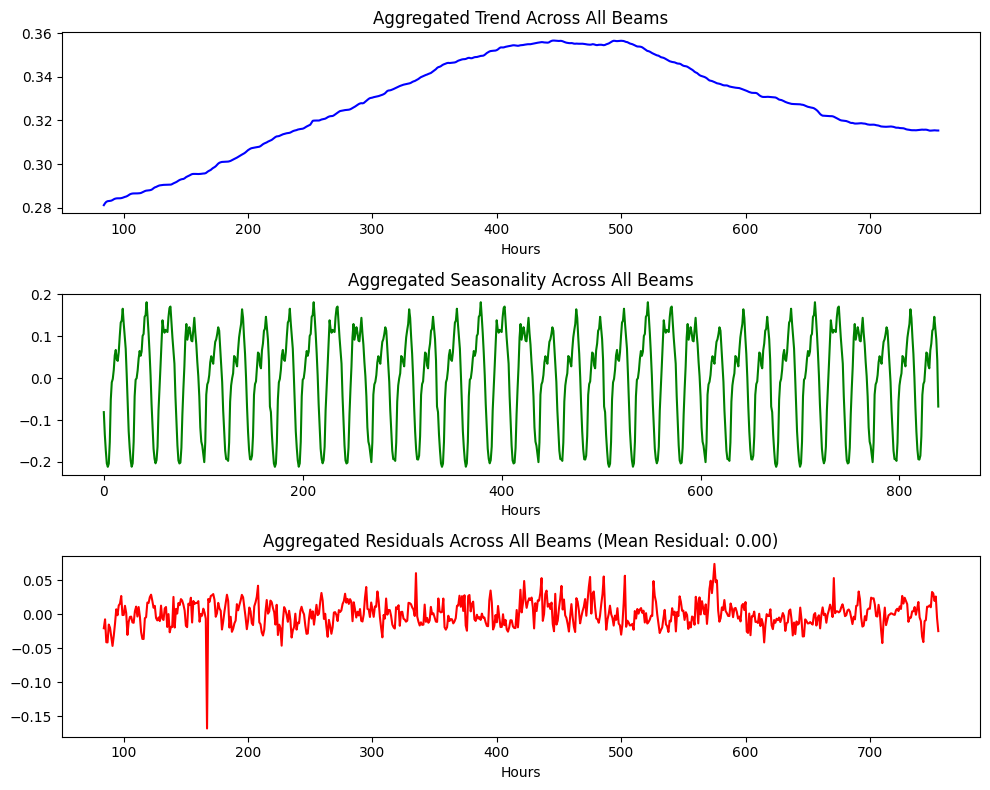

Time Series Decomposition Statistics:
Mean Trend: 0.33, Std Trend: 0.02
Seasonality Peak-to-Trough Ratio: -0.86
Residuals Mean: 0.00, Residual Autocorrelation @ 24 hours: 0.15




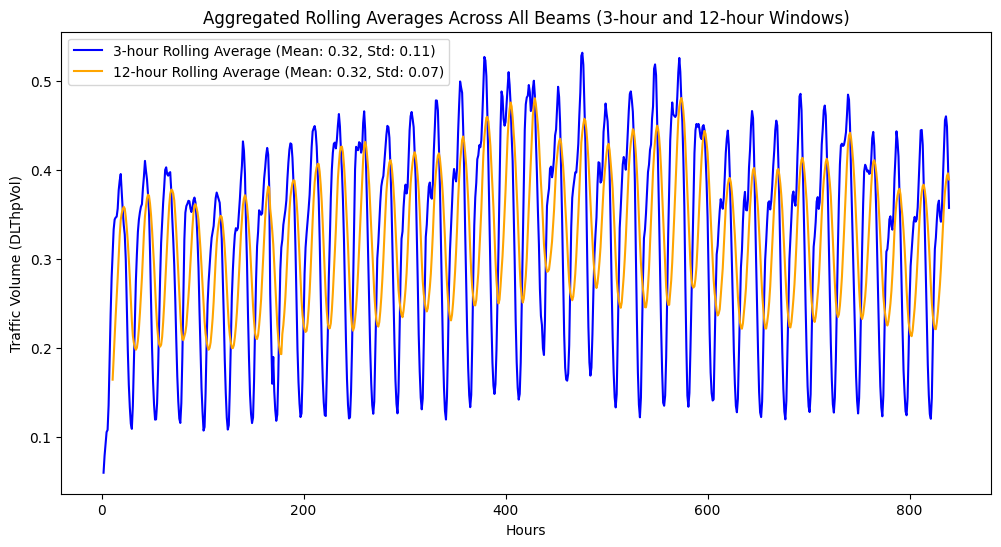

Rolling Averages Statistics:
3-hour Rolling Average (Mean: 0.32, Std: 0.11, Range: 0.47)
12-hour Rolling Average (Mean: 0.32, Std: 0.07, Range: 0.32)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

# ------------------------------
# Data Loading and Exploration
# ------------------------------


# Load datasets
traffic_DLThpVol = '/kaggle/input/spatio-temporal-beam-level-traffic-forecasting/traffic_DLThpVol.csv'
traffic_DLPRB = '/kaggle/input/spatio-temporal-beam-level-traffic-forecasting/traffic_DLPRB.csv'
SampleSubmission = '/kaggle/input/spatio-temporal-beam-level-traffic-forecasting/SampleSubmission.csv'

# Load data into pandas DataFrames
ty = pd.read_csv(traffic_DLThpVol)
prb = pd.read_csv(traffic_DLPRB)
ss = pd.read_csv(SampleSubmission)


# Configuration for beam-level data
n_base, n_cell, n_beam = 30, 3, 32
beam_columns = [f"{base}_{cell}_{beam}" for base in range(n_base) for cell in range(n_cell) for beam in range(n_beam)]
total_hours = len(ty)

### 1. Time Series Decomposition for All Beams ###
# Initialize lists to store aggregated results
all_trends = []
all_seasonality = []
all_residuals = []

# Perform decomposition for each beam and collect the trend, seasonality, and residuals
for beam_col in beam_columns:
    decomposition = seasonal_decompose(ty[beam_col], model='additive', period=24*7)  # Weekly period
    all_trends.append(decomposition.trend)
    all_seasonality.append(decomposition.seasonal)
    all_residuals.append(decomposition.resid)

# Convert lists to DataFrames
avg_trend = pd.DataFrame(all_trends).mean(axis=0)
avg_seasonality = pd.DataFrame(all_seasonality).mean(axis=0)
avg_residuals = pd.DataFrame(all_residuals).mean(axis=0)

# Compute Statistics
trend_mean = avg_trend.mean()
trend_std = avg_trend.std()
seasonality_peak_to_trough_ratio = avg_seasonality.max() / avg_seasonality.min()
residual_autocorrelation = acf(avg_residuals.fillna(0), nlags=24)  # 24-hour autocorrelation
residual_mean = avg_residuals.mean()

# Plot: Aggregated Trend, Seasonality, and Residuals across all beams
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(avg_trend, label=f'Trend (Mean: {trend_mean:.2f}, Std: {trend_std:.2f})', color='blue')
plt.title('Aggregated Trend Across All Beams')
plt.xlabel('Hours')

plt.subplot(3, 1, 2)
plt.plot(avg_seasonality, label=f'Seasonality (Peak-to-Trough Ratio: {seasonality_peak_to_trough_ratio:.2f})', color='green')
plt.title('Aggregated Seasonality Across All Beams')
plt.xlabel('Hours')

plt.subplot(3, 1, 3)
plt.plot(avg_residuals, label=f'Residuals (Autocorrelation @ 24 hours: {residual_autocorrelation[24]:.2f})', color='red')
plt.title(f'Aggregated Residuals Across All Beams (Mean Residual: {residual_mean:.2f})')
plt.xlabel('Hours')

plt.tight_layout()
plt.show()

# Print statistics for Time Series Decomposition
print(f"Time Series Decomposition Statistics:")
print(f"Mean Trend: {trend_mean:.2f}, Std Trend: {trend_std:.2f}")
print(f"Seasonality Peak-to-Trough Ratio: {seasonality_peak_to_trough_ratio:.2f}")
print(f"Residuals Mean: {residual_mean:.2f}, Residual Autocorrelation @ 24 hours: {residual_autocorrelation[24]:.2f}")
print("\n")

### 3. Rolling Averages (3-hour and 12-hour) ###
# Compute rolling averages for all beams
ty['avg_rolling_3'] = ty[beam_columns].rolling(window=3).mean().mean(axis=1)
ty['avg_rolling_12'] = ty[beam_columns].rolling(window=12).mean().mean(axis=1)

# Compute Statistics for Rolling Averages
rolling_3_mean = ty['avg_rolling_3'].mean()
rolling_3_std = ty['avg_rolling_3'].std()
rolling_12_mean = ty['avg_rolling_12'].mean()
rolling_12_std = ty['avg_rolling_12'].std()

rolling_range_3 = ty['avg_rolling_3'].max() - ty['avg_rolling_3'].min()
rolling_range_12 = ty['avg_rolling_12'].max() - ty['avg_rolling_12'].min()

# Plot Rolling Averages
plt.figure(figsize=(12, 6))
plt.plot(ty['avg_rolling_3'], label=f"3-hour Rolling Average (Mean: {rolling_3_mean:.2f}, Std: {rolling_3_std:.2f})", color="blue")
plt.plot(ty['avg_rolling_12'], label=f"12-hour Rolling Average (Mean: {rolling_12_mean:.2f}, Std: {rolling_12_std:.2f})", color="orange")
plt.title("Aggregated Rolling Averages Across All Beams (3-hour and 12-hour Windows)")
plt.xlabel("Hours")
plt.ylabel("Traffic Volume (DLThpVol)")
plt.legend()
plt.show()

# Print statistics for Rolling Averages
print(f"Rolling Averages Statistics:")
print(f"3-hour Rolling Average (Mean: {rolling_3_mean:.2f}, Std: {rolling_3_std:.2f}, Range: {rolling_range_3:.2f})")
print(f"12-hour Rolling Average (Mean: {rolling_12_mean:.2f}, Std: {rolling_12_std:.2f}, Range: {rolling_range_12:.2f})")
print("\n")


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dense, BatchNormalization, Dropout, Flatten, Add, MultiHeadAttention, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor ,callback



# ------------------------
# Feature Engineering
# ------------------------

def create_time_features(df, total_hours):
    """
    Create cyclical time-based features (hour_sin, hour_cos) and flags for weekends and peak hours.
    """
    hours = np.arange(total_hours) % 24
    days = (np.arange(total_hours) // 24) % 7
    df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
    df['hour_cos'] = np.cos(2 * np.pi * hours / 24)
    df['is_weekend'] = ((days == 5) | (days == 6)).astype(int)  # Weekend flag
    df['is_peak_hour'] = np.isin(hours, [7, 8, 9, 17, 18, 19]).astype(int)  # Peak hour flag
    return df

def create_lagged_features(df, beam_columns):
    """
    Create lagged features to capture temporal dependencies in the data.
    Lag intervals: 1 hour, 24 hours, and 168 hours (one week).
    """
    lagged_dfs = [df[beam_columns].shift(lag).add_suffix(f'_lag_{lag}') for lag in [1, 24, 168]]
    return pd.concat([df] + lagged_dfs, axis=1).fillna(0)

def create_congestion_features(prb_data, ty_data, beam_columns, threshold=0.8):
    """
    Create congestion interaction features based on PRB utilization.
    The congestion interaction is a product of high PRB utilization and cyclical time features.
    """
    congestion_ratio = prb_data[beam_columns].mean(axis=1)
    congestion_flag = (congestion_ratio > threshold).astype(float)
    ty_data['congestion_interaction'] = congestion_flag * (ty_data['hour_sin'] + ty_data['hour_cos'])
    return ty_data

def add_rolling_averages(df, beam_columns, windows=[3, 6, 12]):
    """
    Add rolling averages to capture traffic trends.
    Window sizes are 3, 6, and 12 hours to capture short-term fluctuations.
    """
    rolling_dfs = []
    for window in windows:
        rolling_avg = df[beam_columns].rolling(window=window).mean().add_suffix(f'_rolling_{window}')
        rolling_dfs.append(rolling_avg)
    return pd.concat([df] + rolling_dfs, axis=1).fillna(0)

# Apply feature engineering
ty = create_time_features(ty, total_hours)
ty = create_lagged_features(ty, beam_columns)
ty = create_congestion_features(prb, ty, beam_columns)
ty = add_rolling_averages(ty, beam_columns)

# Create Final feature matrix
X = ty[['hour_sin', 'hour_cos', 'is_weekend', 'is_peak_hour', 'congestion_interaction'] +
       [f"{col}_lag_{lag}" for col in beam_columns for lag in [1, 24, 168]] +
       [f"{col}_rolling_{window}" for col in beam_columns for window in [3, 6, 12]]]

# Target variable (traffic throughput volume)
y = ty[beam_columns]



# -------------------------
# Data Splitting and Scaling
# -------------------------

# Split data into train and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for Conv1D(needs time-step dimension)
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_val_scaled = np.expand_dims(X_val_scaled, axis=1)

# ------------------------------
# Neural Network Model
# ------------------------------

def build_neural_network_model(input_shape):
    """
    Build a neural network model with Conv1D, GRU, and Multi-Head Attention layers.
    """
    input_layer = Input(shape=input_shape)

    # Convolutional layers (Dilated Convolution)
    conv1 = Conv1D(filters=64, kernel_size=3, dilation_rate=2, padding='causal', activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, dilation_rate=4, padding='causal', activation='relu', kernel_regularizer=l2(1e-4))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)

    # Residual connection
    res1 = Add()([conv1, conv2])

    # GRU layer for capturing sequential dependencies
    gru_out = GRU(units=64, return_sequences=True, kernel_regularizer=l2(1e-4))(res1)

    # Multi-Head Attention for temporal attention
    attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)

    # Concatenate GRU and Attention outputs
    concat = Concatenate()([attention_out, res1])
    flatten = Flatten()(concat)

    # Output layer
    output_layer = Dense(len(beam_columns), activation='linear')(flatten)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return model


# Build the neural network model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
nn_model = build_neural_network_model(input_shape)

# ------------------------------
# Model Training
# ------------------------------

# Callbacks to prevent overfitting and adjust learning rate

early_stopping = EarlyStopping(monitor='val_mae', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6)

### Train the Neural Network ###
history = nn_model.fit(
    X_train_scaled, y_train.values,
    epochs=100, batch_size=32,
    validation_data=(X_val_scaled, y_val.values),
    callbacks=[early_stopping, reduce_lr]
)


# ------------------------------
# XGBoost Model Training
# ------------------------------

# Define a custom callback for XGBoost to log progress
class XGBoostCallback(callback.TrainingCallback):
    def __init__(self):
        self.iterations = 0

    def after_iteration(self, model, epoch, evals_log):
        self.iterations += 1
        if self.iterations % 10 == 0:
            val_mae = evals_log['validation_0']['mae'][-1]
            print(f"[XGBoost Iteration {self.iterations}] Validation MAE: {val_mae}")
        return False

# Train XGBoost on residuals
print("Training XGBoost model starting...")
### XGBoost Model ###
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.05, max_depth=3,  max_bin=128, objective='reg:squarederror' , device='cuda')

# Flatten the data for XGBoost
X_train_flattened = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_val_flattened = X_val_scaled.reshape(X_val_scaled.shape[0], -1)

# Train the XGBoost model
# Train the model with a custom callback to log progress
xgb_model.fit(
    X_train_flattened, 
    y_train, 
    eval_set=[(X_train_flattened, y_train)],
    eval_metric='mae',
    callbacks=[XGBoostCallback()]
)

# ------------------------------
# Blending Neural Network and XGBoost Predictions
# ------------------------------

# Neural network predictions
y_pred_val_nn = nn_model.predict(X_val_scaled)

# XGBoost predictions
y_pred_val_xgb = xgb_model.predict(X_val_flattened)

# Blend the predictions from both models
weights = [(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5)]
best_mae = float('inf')
best_weights = None

# Find the best blending weights by minimizing MAE
for w_xgb, w_nn in weights:
    blended_pred = (w_xgb * y_pred_val_xgb) + (w_nn * y_pred_val_nn)
    mae = mean_absolute_error(y_val, blended_pred)
    print(f"Weights ({w_xgb}, {w_nn}) - Validation MAE: {mae}")
    
    if mae < best_mae:
        best_mae = mae
        best_weights = (w_xgb, w_nn)

print(f"Best Weights: {best_weights}, Best Validation MAE: {best_mae}")


### Predict on Test Set ###
X_test = X.iloc[-1008:]  # Assuming the last 1008 rows are the test set
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Neural Network Test Predictions
y_pred_test_nn = nn_model.predict(X_test_scaled)

# Flatten test set for XGBoost
X_test_flattened = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# XGBoost Test Predictions
y_pred_test_xgb = xgb_model.predict(X_test_flattened)

# Blend the test predictions using the best weights
w_xgb, w_nn = best_weights
final_test_predictions = (w_xgb * y_pred_test_xgb) + (w_nn * y_pred_test_nn)

# Prepare submission dictionary
submission_dict = {}
for i, pred in enumerate(final_test_predictions):
    for j, value in enumerate(pred):
        hour = i % 168
        mod_col = beam_columns[j]
        submission_dict[f'traffic_DLThpVol_test_5w-6w_{hour}_{mod_col}'] = value
        submission_dict[f'traffic_DLThpVol_test_10w-11w_{hour}_{mod_col}'] = value

# Create submission file
ss['Target'] = ss['ID'].map(submission_dict)
ss.to_csv('mariokart.csv', index=False)
print("Submission file saved as 'stacked_model_submission.csv'")


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4781 - mae: 0.4528

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.4729 - mae: 0.4480 - val_loss: 0.4252 - val_mae: 0.4061 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3386 - mae: 0.3197 - val_loss: 0.3062 - val_mae: 0.2887 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2722 - mae: 0.2551 - val_loss: 0.2494 - val_mae: 0.2335 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2450 - mae: 0.2295 - val_loss: 0.2282 - val_mae: 0.2138 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2333 - mae: 0.2193 - val_loss: 0.2187 - val_mae: 0.2056 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2301 - mae: 0.2172 - val_loss: 0.2130 - val_mae: 0.2009 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2242 - mae: 0.2123 - val_loss: 0.2106 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 8/100
21/21 

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:0.36380
[1]	validation_0-mae:0.34881
[2]	validation_0-mae:0.33467
[3]	validation_0-mae:0.32135
[4]	validation_0-mae:0.30875
[5]	validation_0-mae:0.29688
[6]	validation_0-mae:0.28569
[7]	validation_0-mae:0.27513
[8]	validation_0-mae:0.26518
[9]	validation_0-mae:0.25581
[XGBoost Iteration 10] Validation MAE: 0.25581022822584526
[10]	validation_0-mae:0.24698
[11]	validation_0-mae:0.23867
[12]	validation_0-mae:0.23085
[13]	validation_0-mae:0.22349
[14]	validation_0-mae:0.21657
[15]	validation_0-mae:0.21006
[16]	validation_0-mae:0.20395
[17]	validation_0-mae:0.19819
[18]	validation_0-mae:0.19278
[19]	validation_0-mae:0.18771
[XGBoost Iteration 20] Validation MAE: 0.187707418057956
[20]	validation_0-mae:0.18294
[21]	validation_0-mae:0.17844
[22]	validation_0-mae:0.17422
[23]	validation_0-mae:0.17025
[24]	validation_0-mae:0.16652
[25]	validation_0-mae:0.16301
[26]	validation_0-mae:0.15970
[27]	validation_0-mae:0.15659
[28]	validation_0-mae:0.15364
[29]	validation_0-mae:0.

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:16:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Weights (0.1, 0.9) - Validation MAE: 0.18623376136356878
Weights (0.2, 0.8) - Validation MAE: 0.18099589663665638
Weights (0.3, 0.7) - Validation MAE: 0.17643399161255963
Weights (0.4, 0.6) - Validation MAE: 0.17257705582744348
Weights (0.5, 0.5) - Validation MAE: 0.16942429018724148
Best Weights: (0.5, 0.5), Best Validation MAE: 0.16942429018724148
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Submission file saved as 'stacked_model_submission.csv'
